In [10]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

from scipy.ndimage import zoom

import os

import tensorflow as tf

In [11]:
# Extract http://archive.ics.uci.edu/ml/machine-learning-databases/00447/ to same directory as this script



# List files

one = ['TS1.txt', 'TS2.txt', 'TS3.txt', 'TS4.txt', 'VS1.txt', 'CE.txt', 'CP.txt', 'SE.txt']

ten = ['FS1.txt', 'FS2.txt']

hundred = ['PS1.txt', 'PS2.txt', 'PS3.txt', 'PS4.txt', 'PS5.txt', 'PS6.txt', 'EPS1.txt']



In [12]:
# Parse condition profiles

df_profile = pd.read_table('profile.txt', header=None)

df_profile = df_profile.values.reshape(2205, 1, 5)

df_profile = zoom(df_profile, (1,6000,1))



# Parse 1 Hz measurements

df_one =  np.stack([pd.read_table(x, header=None) for x in one], axis=2)

df_one = zoom(df_one, (1, 100, 1))



# Parse 10 Hz measurements

df_ten =  np.stack([pd.read_table(x, header=None) for x in ten], axis=2)

df_ten = zoom(df_ten, (1, 10, 1))



# Parse 100 Hz measurements

df_hundred = np.stack([pd.read_table(x, header=None) for x in hundred], axis=2)

In [13]:
# Concatenate all data

df = np.concatenate([df_profile, df_one, df_ten, df_hundred], axis=2)



In [14]:
# Split data into training, validation, and test sets

val = 0.2

test = 0.1

train = 1 - val - test



X_train = df[:int(train*df.shape[0])+1:,::,[i not in [1] for i in range(df.shape[2])]]

X_val = df[int(train*df.shape[0])+1:int(train*df.shape[0])+int(val*df.shape[0])+1:,::,[i not in [1] for i in range(df.shape[2])]]

X_test = df[int(train*df.shape[0])+int(val*df.shape[0])+1::,::,[i not in [1] for i in range(df.shape[2])]]



oh_target = (np.arange(df[:,0,1].max()+1) == df[:,0,1][...,None]).astype(int)

oh_target = np.delete(oh_target,np.where(~oh_target.any(axis=0))[0], axis=1)



y_train = oh_target[:int(train*oh_target.shape[0])+1:,]

y_val = oh_target[int(train*oh_target.shape[0])+1:int(train*oh_target.shape[0])+int(val*oh_target.shape[0])+1:,]

y_test = oh_target[int(train*oh_target.shape[0])+int(val*oh_target.shape[0])+1::,]



In [15]:
def sample_batch(X, y, batch_size):

    for b in range(0, len(X)-(len(X)%batch_size)-batch_size, batch_size):

        yield X[b:b + batch_size], y[b:b + batch_size]



# Constants

samples, seq_len, features = X_train.shape

n_classes = y_train.shape[1]



# Hyperparameters

lstm_size = 3*features

lstm_layers = 2

dropout = 0.8

batch_size = 50

learning_rate = 0.0001  # default is 0.001

epochs = 1



graph = tf.Graph()



with graph.as_default():

    inputs = tf.placeholder(dtype=tf.float32, shape=[None, seq_len, features], name='inputs')

    with tf.name_scope("Target"):

        target = tf.placeholder(dtype=tf.int32, shape=[None, n_classes], name='target')

    keep_prob = tf.placeholder(tf.float32, name = 'keep')



with graph.as_default():

    lstm_in = tf.transpose(inputs, [1, 0, 2])  # reshape into (seq_len, samples, features)

    lstm_in = tf.reshape(lstm_in, [-1, features])  # Now (seq_len*samples, features)



    # To cells

    lstm_in = tf.layers.dense(lstm_in, lstm_size, activation=None)



    # Open up the tensor into a list of seq_len pieces

    lstm_in = tf.split(lstm_in, seq_len, 0)



    # Add LSTM layers

    lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)

    drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob)

    cell = tf.contrib.rnn.MultiRNNCell([drop] * lstm_layers)

    initial_state = cell.zero_state(batch_size, tf.float32)



with graph.as_default():

    outputs, final_state = tf.contrib.rnn.static_rnn(cell, lstm_in, dtype=tf.float32, initial_state=initial_state)



    # We only need the last output tensor to pass into a classifier

    logits = tf.layers.dense(outputs[-1], n_classes, name='logits')



    # Cost function and optimizer

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=target))



    # No grad clipping

    # optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)



    # Grad clipping

    train_op = tf.train.AdamOptimizer(learning_rate)



    gradients = train_op.compute_gradients(cost)

    capped_gradients = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gradients]

    optimizer = train_op.apply_gradients(capped_gradients)



    # Accuracy

    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(target, 1))

    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')



if (os.path.exists('checkpoints') == False):

    os.system('mkdir checkpoints')



train_acc = []

train_loss = []



validation_acc = []

validation_loss = []



with graph.as_default():

    saver = tf.train.Saver()



with tf.Session(graph=graph) as sess:

    sess.run(tf.global_variables_initializer())

    iteration = 1



    for e in range(epochs):

        # Initialize

        state = sess.run(initial_state)



        # Loop over batches

        for x, y in sample_batch(X_train, y_train, batch_size):



            # Feed dictionary

            feed = {inputs: x, target: y, keep_prob: dropout, initial_state: state}



            loss, _, state, acc = sess.run([cost, optimizer, final_state, accuracy],

                                           feed_dict=feed)

            train_acc.append(acc)

            train_loss.append(loss)



            # Print at each 5 iters

            if (iteration % 5 == 0):

                print("Epoch: {}/{}".format(e+1, epochs),

                      "Iteration: {:d}".format(iteration),

                      "Train loss: {:6f}".format(loss),

                      "Train acc: {:.6f}".format(acc))



            # Compute validation loss at every 25 iterations

            if (iteration % 25 == 0):



                # Initiate for validation set

                val_state = sess.run(cell.zero_state(batch_size, tf.float32))



                val_acc_ = []

                val_loss_ = []

                for x_v, y_v in sample_batch(X_val, y_val, batch_size):

                    # Feed

                    feed = {inputs: x_v, target: y_v, keep_prob: 1.0, initial_state: val_state}



                    # Loss

                    loss_v, state_v, acc_v = sess.run([cost, final_state, accuracy], feed_dict=feed)



                    val_acc_.append(acc_v)

                    val_loss_.append(loss_v)



                # Print info

                print("Epoch: {}/{}".format(e+1, epochs),

                      "Iteration: {:d}".format(iteration),

                      "Validation loss: {:6f}".format(np.mean(val_loss_)),

                      "Validation acc: {:.6f}".format(np.mean(val_acc_)))



                # Store

                validation_acc.append(np.mean(val_acc_))

                validation_loss.append(np.mean(val_loss_))



            # Iterate

            iteration += 1



    saver.save(sess, "checkpoints/lstm.ckpt")

Epoch: 1/1 Iteration: 5 Train loss: 1.357857 Train acc: 0.360000
Epoch: 1/1 Iteration: 10 Train loss: 1.336112 Train acc: 0.360000
Epoch: 1/1 Iteration: 15 Train loss: 1.321885 Train acc: 0.540000
Epoch: 1/1 Iteration: 20 Train loss: 1.424419 Train acc: 0.220000
Epoch: 1/1 Iteration: 25 Train loss: 1.365082 Train acc: 0.360000
Epoch: 1/1 Iteration: 25 Validation loss: 1.247948 Validation acc: 0.560000


In [16]:
def sample_batch(X, y, batch_size):

    for b in range(0, len(X)-(len(X)%batch_size)-batch_size, batch_size):

        yield X[b:b + batch_size], y[b:b + batch_size]



# Constants

samples, seq_len, features = X_train.shape

n_classes = y_train.shape[1]



# Hyperparameters

lstm_size = 3*features

lstm_layers = 2

dropout = 0.8

batch_size = 100

learning_rate = 0.0001  # default is 0.001

epochs = 3



graph = tf.Graph()



with graph.as_default():

    inputs = tf.placeholder(dtype=tf.float32, shape=[None, seq_len, features], name='inputs')

    with tf.name_scope("Target"):

        target = tf.placeholder(dtype=tf.int32, shape=[None, n_classes], name='target')

    keep_prob = tf.placeholder(tf.float32, name = 'keep')



with graph.as_default():

    lstm_in = tf.transpose(inputs, [1, 0, 2])  # reshape into (seq_len, samples, features)

    lstm_in = tf.reshape(lstm_in, [-1, features])  # Now (seq_len*samples, features)



    # To cells

    lstm_in = tf.layers.dense(lstm_in, lstm_size, activation=None)



    # Open up the tensor into a list of seq_len pieces

    lstm_in = tf.split(lstm_in, seq_len, 0)



    # Add LSTM layers

    lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)

    drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob)

    cell = tf.contrib.rnn.MultiRNNCell([drop] * lstm_layers)

    initial_state = cell.zero_state(batch_size, tf.float32)



with graph.as_default():

    outputs, final_state = tf.contrib.rnn.static_rnn(cell, lstm_in, dtype=tf.float32, initial_state=initial_state)



    # We only need the last output tensor to pass into a classifier

    logits = tf.layers.dense(outputs[-1], n_classes, name='logits')



    # Cost function and optimizer

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=target))



    # No grad clipping

    # optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)



    # Grad clipping

    train_op = tf.train.AdamOptimizer(learning_rate)



    gradients = train_op.compute_gradients(cost)

    capped_gradients = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gradients]

    optimizer = train_op.apply_gradients(capped_gradients)



    # Accuracy

    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(target, 1))

    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')



if (os.path.exists('checkpoints') == False):

    os.system('mkdir checkpoints')



train_acc = []

train_loss = []



validation_acc = []

validation_loss = []



with graph.as_default():

    saver = tf.train.Saver()



with tf.Session(graph=graph) as sess:

    sess.run(tf.global_variables_initializer())

    iteration = 2



    for e in range(epochs):

        # Initialize

        state = sess.run(initial_state)



        # Loop over batches

        for x, y in sample_batch(X_train, y_train, batch_size):



            # Feed dictionary

            feed = {inputs: x, target: y, keep_prob: dropout, initial_state: state}



            loss, _, state, acc = sess.run([cost, optimizer, final_state, accuracy],

                                           feed_dict=feed)

            train_acc.append(acc)

            train_loss.append(loss)



            # Print at each 5 iters

            if (iteration % 5 == 0):

                print("Epoch: {}/{}".format(e+1, epochs),

                      "Iteration: {:d}".format(iteration),

                      "Train loss: {:6f}".format(loss),

                      "Train acc: {:.6f}".format(acc))



            # Compute validation loss at every 25 iterations

            if (iteration % 25 == 0):



                # Initiate for validation set

                val_state = sess.run(cell.zero_state(batch_size, tf.float32))



                val_acc_ = []

                val_loss_ = []

                for x_v, y_v in sample_batch(X_val, y_val, batch_size):

                    # Feed

                    feed = {inputs: x_v, target: y_v, keep_prob: 1.0, initial_state: val_state}



                    # Loss

                    loss_v, state_v, acc_v = sess.run([cost, final_state, accuracy], feed_dict=feed)



                    val_acc_.append(acc_v)

                    val_loss_.append(loss_v)



                # Print info

                print("Epoch: {}/{}".format(e+1, epochs),

                      "Iteration: {:d}".format(iteration),

                      "Validation loss: {:6f}".format(np.mean(val_loss_)),

                      "Validation acc: {:.6f}".format(np.mean(val_acc_)))



                # Store

                validation_acc.append(np.mean(val_acc_))

                validation_loss.append(np.mean(val_loss_))



            # Iterate

            iteration += 1



    saver.save(sess, "checkpoints/lstm.ckpt")

Epoch: 1/3 Iteration: 5 Train loss: 1.406535 Train acc: 0.240000
Epoch: 1/3 Iteration: 10 Train loss: 1.343435 Train acc: 0.030000
Epoch: 1/3 Iteration: 15 Train loss: 1.405002 Train acc: 0.230000
Epoch: 2/3 Iteration: 20 Train loss: 1.408165 Train acc: 0.220000
Epoch: 2/3 Iteration: 25 Train loss: 1.291842 Train acc: 0.510000
Epoch: 2/3 Iteration: 25 Validation loss: 1.299136 Validation acc: 0.600000
Epoch: 3/3 Iteration: 30 Train loss: 1.146003 Train acc: 0.830000
Epoch: 3/3 Iteration: 35 Train loss: 1.411832 Train acc: 0.290000
Epoch: 3/3 Iteration: 40 Train loss: 1.402940 Train acc: 0.320000


In [21]:
# For Data Exploration

# Convert into dataframe by separating the data into features and targets

features = np.concatenate([df_one, df_ten, df_hundred], axis=2)
def mean_conversion(df):
    df = pd.DataFrame()
    df = features.mean(axis = 1)
    return df
df = pd.DataFrame(mean_conversion(features))
df.columns = ["TS1", "TS2", "TS3", "TS4", "VS1", "CE", "CP", "SE", "FS1", "FS2","PS1", "PS2", "PS3", "PS4", "PS5", "PS6", "EPS1" ]


targets = np.concatenate([df_profile], axis=2)
def mean_conversion(df2):
    df2 = pd.DataFrame()
    df2 = targets.mean(axis = 1)
    return df2
df2 = pd.DataFrame(mean_conversion(targets))
df2.columns = ["Cooler_efficiency", "Valve_response", "Pump_leakage", "Accumulator_pressure", "Instability_flag" ]


[[<matplotlib.axes._subplots.AxesSubplot object at 0x0000027A3DC3B710>


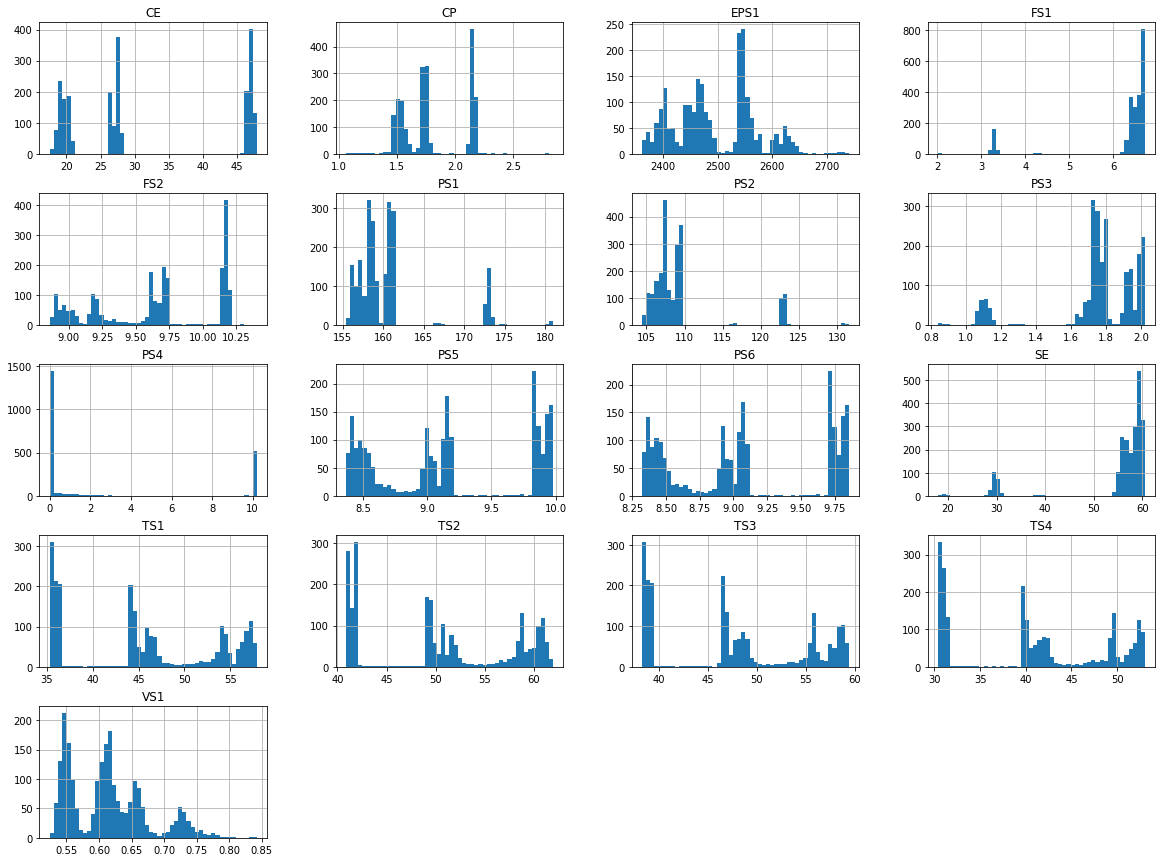

In [23]:

# Create visualization using histogram
print(df.hist(bins=50, figsize=(20, 15)))

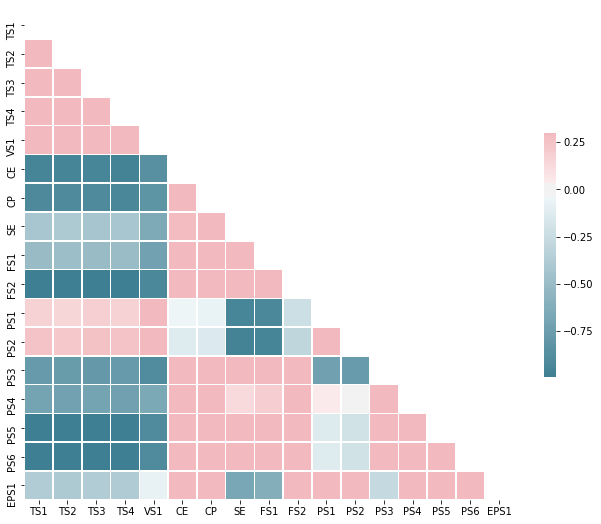

In [24]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize correlations among the variables
corr_matrix = df.corr()

#plot heat map for correlation matrix (from https://seaborn.pydata.org/examples/many_pairwise_correlations.html)

# Generate a mask for the upper triangle
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Text(0.5, 1.0, 'PCA explained variance vs. n componets')

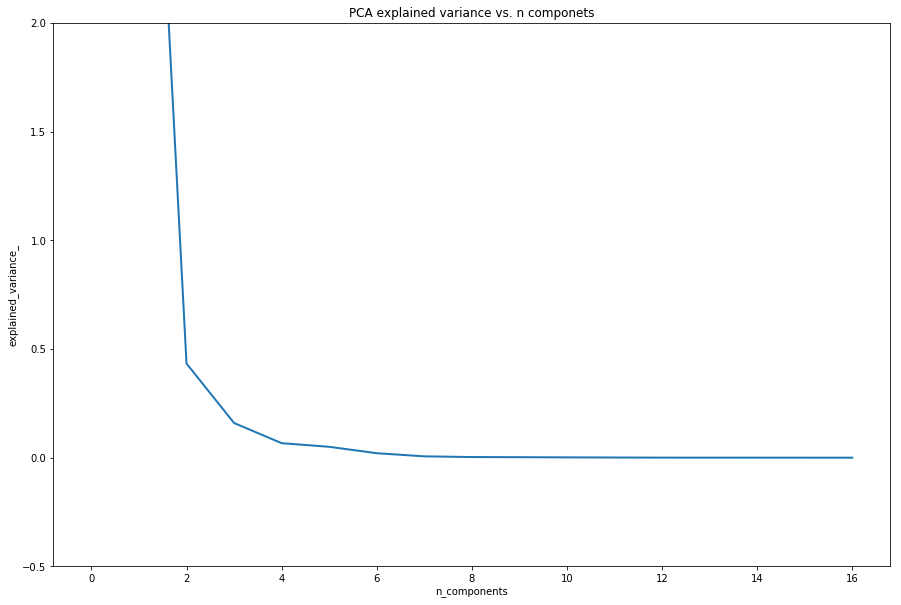

In [25]:
from sklearn.preprocessing import StandardScaler

#Normalize the features values
df_normalize = StandardScaler().fit_transform(df)

#Apply PCA to visulaize the data in cluster
from sklearn.decomposition import PCA
#Explained variance and n_components

pca = PCA()
pca.fit(df_normalize)
plt.figure(figsize=(15, 10))
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')
plt.ylim(-0.5, 2)
plt.title('PCA explained variance vs. n componets')

(2205, 17)
(2205, 2)


Text(0.5, 1.0, 'Clustering of data with PCA dimension =2')

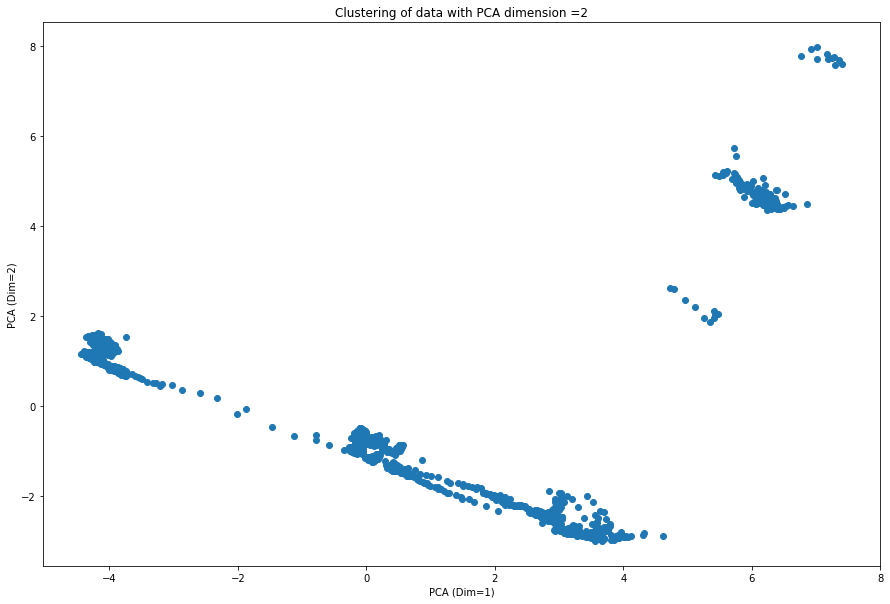

In [26]:
#Observation of the distribution when n_componets = 2
pca_2 = PCA(2)
projected = pca_2.fit_transform(df_normalize)
print(df.shape)
print(projected.shape)
plt.figure(figsize=(15, 10))
plt.scatter(projected[:, 0], projected[:,1])
plt.xlabel('PCA (Dim=1)')
plt.ylabel('PCA (Dim=2)')
plt.title('Clustering of data with PCA dimension =2')

In [34]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import xgboost as xgb
import os

In [35]:
# Seperating the Profile into each target variables
y_coolerCondition = pd.DataFrame(df2.iloc[:, 0])
y_valveCondition = pd.DataFrame(df2.iloc[:, 1])
y_pumpLeak = pd.DataFrame(df2.iloc[:, 2])
y_hydraulicAcc = pd.DataFrame(df2.iloc[:, 3])
y_stableFlag = pd.DataFrame(df2.iloc[:, 4])

In [52]:
def predict_pump_performance(X, y, predictType):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)
    
    X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=24)
    
    #Apply xgboost for classification
    seed= 24
    xgb1 = xgb.sklearn.XGBClassifier(
            learning_rate =0.1,
             n_estimators=100,
             max_depth=5,
             min_child_weight=11,
             gamma=0.1,
             subsample=0.8,
             colsample_bytree=0.7,
             objective='multi:softprob',
             n_jobs=-1,
             scale_pos_weight=1,
             seed=seed)
    
    xgb1.fit(X_train, y_train)
    
    y_pred= xgb1.predict(X_val)
    
    #confusion matrix and classification report
    
    cm = confusion_matrix(y_val, y_pred)
    
    print(classification_report(y_val, y_pred))
    
    
    fig, ax = plt.subplots(figsize = (15, 10))
    ind = np.arange(17)
    width = 0.15
    feature_importance = xgb1.feature_importances_
    rect1 = ax.bar(ind+width, feature_importance)
    ax.set_xticks(ind+width/2)
    ax.set_xticklabels(('PS1', 'PS2', 'PS3', 'PS4', 'PS5', 'PS6', 'FS1', 'FS2', 'TS1', 'TS2', 'TS3', 'TS4', 'P1', 'VS1', 'CE', 'CP', 'SE'))
    ax.set_ylabel('Importance')
    ax.set_xlabel('Measurements')
    ax.set_title('Relative Importance of measurements to predict ' + predictType)
    plt.show()

C:\Users\Remi_Adefioye\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Remi_Adefioye\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

         3.0       1.00      1.00      1.00        82
        20.0       1.00      1.00      1.00        70
       100.0       1.00      1.00      1.00        69

   micro avg       1.00      1.00      1.00       221
   macro avg       1.00      1.00      1.00       221
weighted avg       1.00      1.00      1.00       221



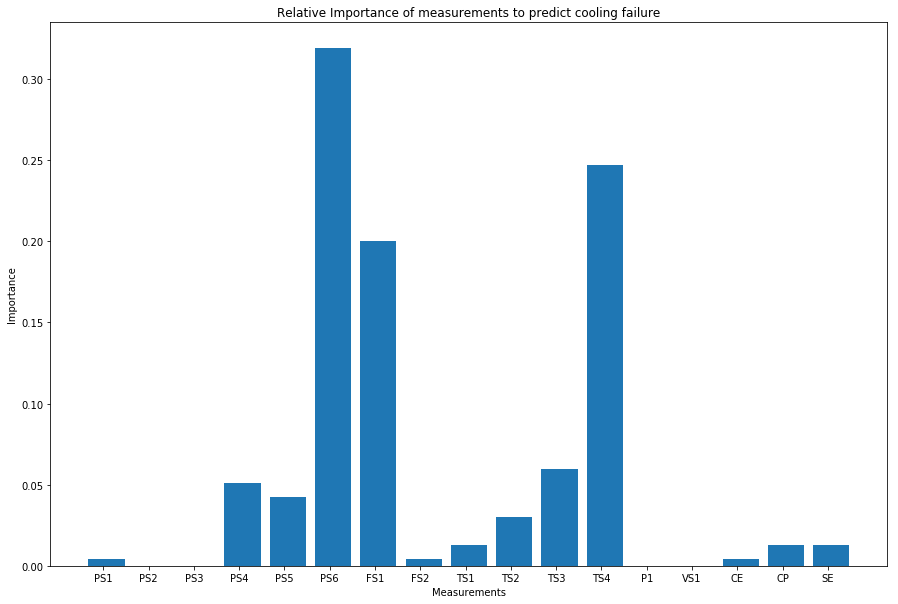

In [51]:
#let's predict the cooling failure
predict_pump_performance(df_normalize, y_coolerCondition, 'cooling failure')

C:\Users\Remi_Adefioye\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Remi_Adefioye\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

        73.0       0.95      1.00      0.97        39
        80.0       1.00      0.95      0.97        41
        90.0       0.89      0.77      0.83        31
       100.0       0.94      0.97      0.96       110

   micro avg       0.95      0.95      0.95       221
   macro avg       0.94      0.92      0.93       221
weighted avg       0.95      0.95      0.94       221



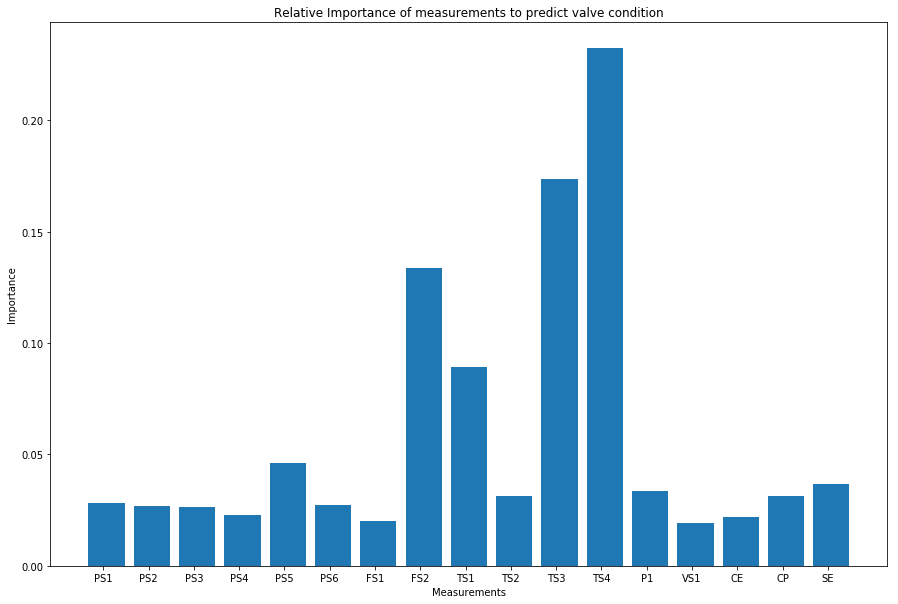

In [53]:
predict_pump_performance(df_normalize, y_valveCondition, 'valve condition')

C:\Users\Remi_Adefioye\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Remi_Adefioye\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00       125
         1.0       0.96      0.98      0.97        54
         2.0       0.98      0.98      0.98        42

   micro avg       0.99      0.99      0.99       221
   macro avg       0.98      0.98      0.98       221
weighted avg       0.99      0.99      0.99       221



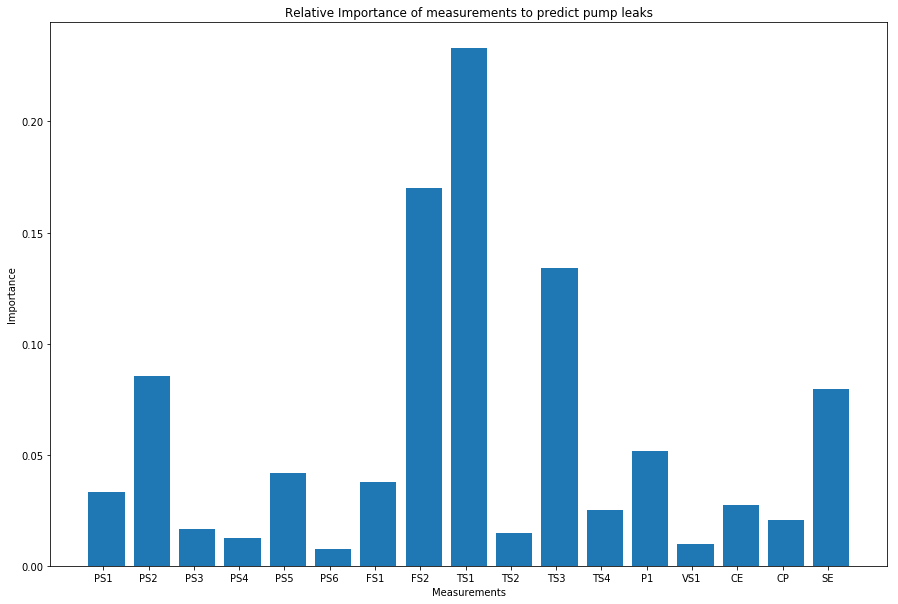

In [54]:
predict_pump_performance(df_normalize, y_pumpLeak, 'pump leaks')

C:\Users\Remi_Adefioye\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Remi_Adefioye\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

        90.0       1.00      0.94      0.97        78
       100.0       0.95      0.95      0.95        38
       115.0       0.88      1.00      0.94        36
       130.0       1.00      1.00      1.00        69

   micro avg       0.97      0.97      0.97       221
   macro avg       0.96      0.97      0.96       221
weighted avg       0.97      0.97      0.97       221



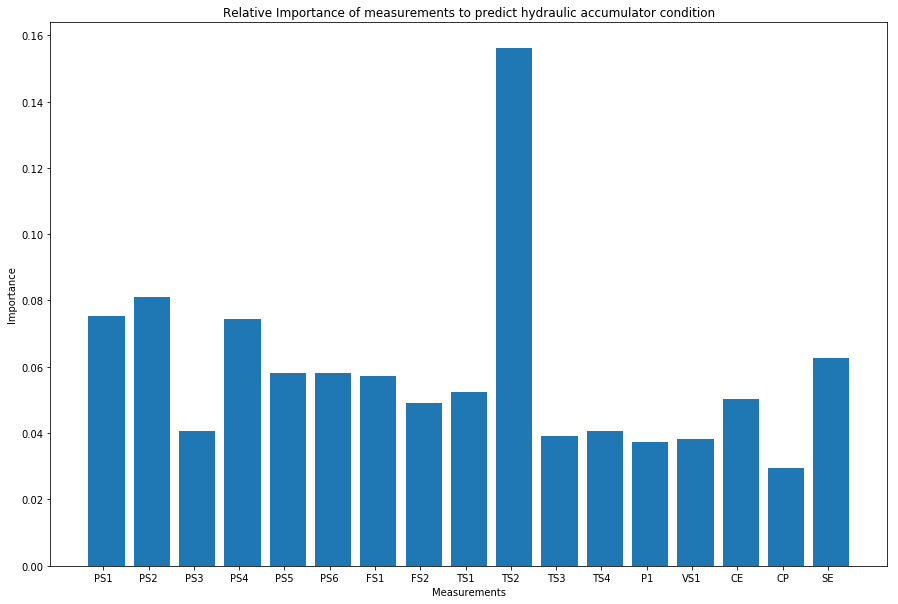

In [55]:
predict_pump_performance(df_normalize, y_hydraulicAcc, 'hydraulic accumulator condition')

In [47]:
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import BatchNormalization
from keras.layers import Dropout
import matplotlib.pyplot as plt
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import robust_scale
from sklearn.pipeline import Pipeline
from scipy import stats

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import numpy
# fix random seed for reproducibility
seed = 823
np.random.seed(seed)


df.shape
y_valveCondition.shape

#Create Predictors and Target Dfs
X_predictors = df
y_target = y_valveCondition

X_predictors.shape


#Convert Target Classes to One Hot Encoded Matrix
y_target_matrix = np_utils.to_categorical(y_target)


y_target_matrix.shape


# define baseline model
def baseline_model():
	# create model
	base_model = Sequential()
	base_model.add(Dense(50, input_dim=17, activation='relu'))
	base_model.add(BatchNormalization())
	base_model.add(Dropout(0.5))
	base_model.add(Dense(50,activation='relu'))
	base_model.add(Dropout(0.5))
	base_model.add(BatchNormalization())
	base_model.add(Dense(50,activation='relu'))
	base_model.add(Dense(101, activation='softmax'))
	# Compile model
	base_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return base_model

base_estimator = KerasClassifier(build_fn=baseline_model, epochs=110, batch_size=30, verbose=1) #Change epochs to 10, batch_size to 2201

#fit model
base_estimator.fit(X_predictors, y_target_matrix)


Epoch 1/110
2205/2205 [==============================] - 1s 526us/step - loss: 3.4566 - acc: 0.2780
Epoch 2/110
2205/2205 [==============================] - 0s 194us/step - loss: 1.5648 - acc: 0.4834
Epoch 3/110
2205/2205 [==============================] - 0s 154us/step - loss: 1.2771 - acc: 0.5002
Epoch 4/110
2205/2205 [==============================] - 0s 175us/step - loss: 1.2698 - acc: 0.4925
Epoch 5/110
2205/2205 [==============================] - 0s 189us/step - loss: 1.2189 - acc: 0.5070
Epoch 6/110
2205/2205 [==============================] - 0s 171us/step - loss: 1.2116 - acc: 0.5061
Epoch 7/110
2205/2205 [==============================] - 1s 258us/step - loss: 1.2019 - acc: 0.5066
Epoch 8/110
2205/2205 [==============================] - 0s 162us/step - loss: 1.1968 - acc: 0.5011
Epoch 9/110
2205/2205 [==============================] - 0s 150us/step - loss: 1.1850 - acc: 0.5066
Epoch 10/110
2205/2205 [==============================] - 0s 151us/step - loss: 1.1769 - acc: 0.5138

Epoch 82/110
2205/2205 [==============================] - 1s 231us/step - loss: 0.7732 - acc: 0.6707
Epoch 83/110
2205/2205 [==============================] - 0s 166us/step - loss: 0.7704 - acc: 0.6667
Epoch 84/110
2205/2205 [==============================] - 0s 147us/step - loss: 0.7495 - acc: 0.6844
Epoch 85/110
2205/2205 [==============================] - 0s 153us/step - loss: 0.7491 - acc: 0.6834
Epoch 86/110
2205/2205 [==============================] - 0s 200us/step - loss: 0.7328 - acc: 0.6943
Epoch 87/110
2205/2205 [==============================] - 0s 144us/step - loss: 0.7226 - acc: 0.6893
Epoch 88/110
2205/2205 [==============================] - 0s 149us/step - loss: 0.7425 - acc: 0.6807
Epoch 89/110
2205/2205 [==============================] - 0s 212us/step - loss: 0.7314 - acc: 0.6916
Epoch 90/110
2205/2205 [==============================] - 0s 160us/step - loss: 0.6900 - acc: 0.7088
Epoch 91/110
2205/2205 [==============================] - 0s 197us/step - loss: 0.7648 - ac

In [48]:
def sample_batch(X, y, batch_size):

    for b in range(0, len(X)-(len(X)%batch_size)-batch_size, batch_size):

        yield X[b:b + batch_size], y[b:b + batch_size]



# Constants

samples, seq_len, features = X_train.shape

n_classes = y_train.shape[1]



# Hyperparameters

lstm_size = 3*features

lstm_layers = 2

dropout = 0.8

batch_size = 200

learning_rate = 0.0001  # default is 0.001

epochs = 3



graph = tf.Graph()



with graph.as_default():

    inputs = tf.placeholder(dtype=tf.float32, shape=[None, seq_len, features], name='inputs')

    with tf.name_scope("Target"):

        target = tf.placeholder(dtype=tf.int32, shape=[None, n_classes], name='target')

    keep_prob = tf.placeholder(tf.float32, name = 'keep')



with graph.as_default():

    lstm_in = tf.transpose(inputs, [1, 0, 2])  # reshape into (seq_len, samples, features)

    lstm_in = tf.reshape(lstm_in, [-1, features])  # Now (seq_len*samples, features)



    # To cells

    lstm_in = tf.layers.dense(lstm_in, lstm_size, activation=None)



    # Open up the tensor into a list of seq_len pieces

    lstm_in = tf.split(lstm_in, seq_len, 0)



    # Add LSTM layers

    lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)

    drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob)

    cell = tf.contrib.rnn.MultiRNNCell([drop] * lstm_layers)

    initial_state = cell.zero_state(batch_size, tf.float32)



with graph.as_default():

    outputs, final_state = tf.contrib.rnn.static_rnn(cell, lstm_in, dtype=tf.float32, initial_state=initial_state)



    # We only need the last output tensor to pass into a classifier

    logits = tf.layers.dense(outputs[-1], n_classes, name='logits')



    # Cost function and optimizer

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=target))



    # No grad clipping

    # optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)



    # Grad clipping

    train_op = tf.train.AdamOptimizer(learning_rate)



    gradients = train_op.compute_gradients(cost)

    capped_gradients = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gradients]

    optimizer = train_op.apply_gradients(capped_gradients)



    # Accuracy

    correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(target, 1))

    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')



if (os.path.exists('checkpoints') == False):

    os.system('mkdir checkpoints')



train_acc = []

train_loss = []



validation_acc = []

validation_loss = []



with graph.as_default():

    saver = tf.train.Saver()



with tf.Session(graph=graph) as sess:

    sess.run(tf.global_variables_initializer())

    iteration = 1



    for e in range(epochs):

        # Initialize

        state = sess.run(initial_state)



        # Loop over batches

        for x, y in sample_batch(X_train, y_train, batch_size):



            # Feed dictionary

            feed = {inputs: x, target: y, keep_prob: dropout, initial_state: state}



            loss, _, state, acc = sess.run([cost, optimizer, final_state, accuracy],

                                           feed_dict=feed)

            train_acc.append(acc)

            train_loss.append(loss)



            # Print at each 5 iters

            if (iteration % 5 == 0):

                print("Epoch: {}/{}".format(e+1, epochs),

                      "Iteration: {:d}".format(iteration),

                      "Train loss: {:6f}".format(loss),

                      "Train acc: {:.6f}".format(acc))



            # Compute validation loss at every 25 iterations

            if (iteration % 25 == 0):



                # Initiate for validation set

                val_state = sess.run(cell.zero_state(batch_size, tf.float32))



                val_acc_ = []

                val_loss_ = []

                for x_v, y_v in sample_batch(X_val, y_val, batch_size):

                    # Feed

                    feed = {inputs: x_v, target: y_v, keep_prob: 1.0, initial_state: val_state}



                    # Loss

                    loss_v, state_v, acc_v = sess.run([cost, final_state, accuracy], feed_dict=feed)



                    val_acc_.append(acc_v)

                    val_loss_.append(loss_v)



                # Print info

                print("Epoch: {}/{}".format(e+1, epochs),

                      "Iteration: {:d}".format(iteration),

                      "Validation loss: {:6f}".format(np.mean(val_loss_)),

                      "Validation acc: {:.6f}".format(np.mean(val_acc_)))



                # Store

                validation_acc.append(np.mean(val_acc_))

                validation_loss.append(np.mean(val_loss_))



            # Iterate

            iteration += 1



    saver.save(sess, "checkpoints/lstm.ckpt")

Epoch: 1/3 Iteration: 5 Train loss: 1.268240 Train acc: 0.575000
Epoch: 2/3 Iteration: 10 Train loss: 1.297125 Train acc: 0.485000
Epoch: 3/3 Iteration: 15 Train loss: 1.394961 Train acc: 0.320000


In [ ]:
---------
 #Reference on data exploration-  https://github.com/mjain72/Condition-monitoring-of-hydraulic-systems-using-xgboost-modeling/blob/master/HydraulicCondition.ipynb
---------    